<a href="https://colab.research.google.com/github/aishwarya-annamalai/Demo/blob/main/Project_MINOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [13]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [14]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [15]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


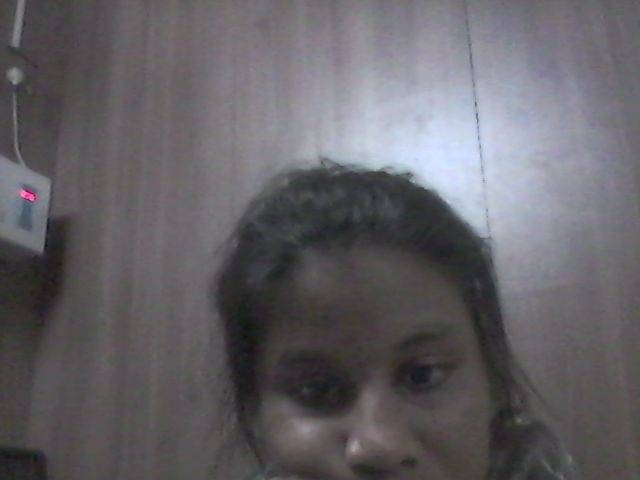

In [16]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [17]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [18]:
!apt install cmake
!pip install dlib
!pip install face_recognition

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [26]:
import os
if not os.path.exists('/content/attendance'):
  os.makedirs('/content/attendance')

In [27]:
image = cv2.imread('/content/attendance/photo.png')

In [32]:
import cv2
import numpy as np
import pandas as pd
from IPython.display import display, Javascript, Image
import face_recognition
from datetime import datetime
from base64 import b64decode
import os
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

# Create an attendance directory if it doesn't exist
attendance_file = 'attendance.xlsx'
if not os.path.exists(attendance_file):
    df = pd.DataFrame(columns=['Name', 'Date', 'Time', 'Status'])
    df.to_excel(attendance_file, index=False)

# Load the known face
person_name = "Aishwarya"  # Name of the person
known_face_image_path = "/content/sample_data/Aishwarya.png"
known_face_image_path1 = "/content/sample_data/Akshaya.png" # Path to the known person's image
known_image = face_recognition.load_image_file(known_face_image_path)
known_face_encoding = face_recognition.face_encodings(known_image)[0]




def js_to_image(data):
    """Convert base64 image data to a NumPy array."""
    header, encoded = data.split(',', 1)
    img_data = b64decode(encoded)
    np_array = np.frombuffer(img_data, np.uint8)
    img = cv2.imdecode(np_array, cv2.IMREAD_COLOR)
    return img

def take_photo(filename='photo.jpg', quality=0.8):
    """Capture a photo from the webcam."""
    js = Javascript('''
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize the output to fit the video element.
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // Wait for Capture to be clicked.
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)

    # Get photo data
    data = eval_js('takePhoto({})'.format(quality))
    img = js_to_image(data)

    # Save the captured image
    cv2.imwrite(filename, img)
    print('Saved to {}'.format(filename))

    return filename

def record_attendance(person_name, status):
    """Record attendance in Excel."""
    now = datetime.now()
    df = pd.read_excel(attendance_file)
    new_entry = pd.DataFrame({'Name': [person_name],
                              'Date': [now.strftime("%Y-%m-%d")],
                              'Time': [now.strftime("%H:%M:%S")],
                              'Status': [status]})
    df = pd.concat([df, new_entry], ignore_index=True)
    df.to_excel(attendance_file, index=False)

# Main logic to capture, recognize, record attendance, and send email
try:
    filename = take_photo('Aishwarya.png')  # Capture the photo
    filename = take_photo('Akshaya.png')
    captured_image = face_recognition.load_image_file(filename)
    captured_face_encodings = face_recognition.face_encodings(captured_image)



    attendance_status = "Absent"  # Default status

    for face_encoding in captured_face_encodings:
        matches = face_recognition.compare_faces([known_face_encoding], face_encoding)
        if matches[0]:  # If a match is found
            attendance_status = "Present"

    # Record attendance
    record_attendance(person_name, attendance_status)
    print(f"Attendance recorded: {person_name} is {attendance_status}.")




except Exception as err:
    print("Error: " + str(err))


<IPython.core.display.Javascript object>

Saved to Aishwarya.png


<IPython.core.display.Javascript object>

Saved to Akshaya.png
Attendance recorded: Aishwarya is Present.


In [40]:
import cv2
import numpy as np
import pandas as pd
from IPython.display import display, Javascript, Javascript
import face_recognition
from datetime import datetime
from base64 import b64decode
import os

#Aishu Project

gmeet_link = "https://meet.google.com/qbs-ziix-nrt"

# Create an attendance directory if it doesn't exist
attendance_file = 'attendance.xlsx'
if not os.path.exists(attendance_file):
    df = pd.DataFrame(columns=['Name', 'Date', 'Time', 'Status','Period'])
    df.to_excel(attendance_file, index=False)

# List of known persons and their image paths
known_persons = ["Aishwarya", "Akshaya"]
known_face_image_paths = [
    "/content/sample_data/Aishwarya.png",
    "/content/sample_data/Akshaya.png",]

# Load known faces and encodings
known_face_encodings = []
for image_path in known_face_image_paths:
    image = face_recognition.load_image_file(image_path)
    encoding = face_recognition.face_encodings(image)[0]
    known_face_encodings.append(encoding)

def js_to_image(data):
    """Convert base64 image data to a NumPy array."""
    header, encoded = data.split(',', 1)
    img_data = b64decode(encoded)
    np_array = np.frombuffer(img_data, np.uint8)
    img = cv2.imdecode(np_array, cv2.IMREAD_COLOR)
    return img

def take_photo(filename='photo.jpg', quality=0.8):
    """Capture a photo from the webcam."""
    js = Javascript('''
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize the output to fit the video element.
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // Wait for Capture to be clicked.
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)

    # Get photo data
    data = eval_js('takePhoto({})'.format(quality))
    img = js_to_image(data)

    # Save the captured image
    cv2.imwrite(filename, img)
    print('Saved to {}'.format(filename))

    return filename

def record_attendance(person_name, status):
    """Record attendance in Excel."""
    now = datetime.now()
    df = pd.read_excel(attendance_file)
    new_entry = pd.DataFrame({'Name': [person_name],
                              'Date': [now.strftime("%Y-%m-%d")],
                              'Time': [now.strftime("%H:%M:%S")],
                              'Status': [status]})
    df = pd.concat([df, new_entry], ignore_index=True)
    df.to_excel(attendance_file, index=False)


# Main logic to capture, recognize, and record attendance
try:
    filename = take_photo('captured_image.jpg')  # Capture the photo
    captured_image = face_recognition.load_image_file(filename)
    captured_face_encodings = face_recognition.face_encodings(captured_image)

    # Dictionary to hold attendance status
    attendance_status_dict = {name: "Absent" for name in known_persons}

    for face_encoding in captured_face_encodings:
        for i, known_encoding in enumerate(known_face_encodings):
            matches = face_recognition.compare_faces([known_encoding], face_encoding)
            if matches[0]:  # If a match is found
                attendance_status_dict[known_persons[i]] = "Present"

    # Record attendance for each person
    for person_name, status in attendance_status_dict.items():
        record_attendance(person_name, status)
        print(f"Attendance recorded: {person_name} is {status}.")

except Exception as err:
    print("Error: " + str(err))



<IPython.core.display.Javascript object>

Saved to captured_image.jpg
Attendance recorded: Aishwarya is Absent.
Attendance recorded: Akshaya is Absent.


In [54]:
import cv2
import numpy as np
import pandas as pd
from IPython.display import display, Javascript
import face_recognition
from datetime import datetime
from base64 import b64decode
import os

# Aishu Project

gmeet_link = "https://meet.google.com/qbs-ziix-nrt"  # Google Meet link

# Create an attendance directory if it doesn't exist
attendance_file = 'attendance.xlsx'
if not os.path.exists(attendance_file):
    df = pd.DataFrame(columns=['Name', 'Date', 'Time', 'Status', 'Period'])
    df.to_excel(attendance_file, index=False)

# List of known persons and their image paths
known_persons = ["Aishwarya", "Akshaya"]
known_face_image_paths = [
    "/content/sample_data/Aishwarya.png",
    "/content/sample_data/Akshaya.png",
]

# Load known faces and encodings
known_face_encodings = []
for image_path in known_face_image_paths:
    image = face_recognition.load_image_file(image_path)
    encoding = face_recognition.face_encodings(image)[0]
    known_face_encodings.append(encoding)

def js_to_image(data):
    """Convert base64 image data to a NumPy array."""
    header, encoded = data.split(',', 1)
    img_data = b64decode(encoded)
    np_array = np.frombuffer(img_data, np.uint8)
    img = cv2.imdecode(np_array, cv2.IMREAD_COLOR)
    return img

def take_photo(filename='photo.jpg', quality=0.8):
    """Capture a photo from the webcam."""
    js = Javascript('''
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize the output to fit the video element.
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // Wait for Capture to be clicked.
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)

    # Get photo data
    data = eval_js('takePhoto({})'.format(quality))
    img = js_to_image(data)

    # Save the captured image
    cv2.imwrite(filename, img)
    print('Saved to {}'.format(filename))

    return filename

def record_attendance(person_name, status):
    """Record attendance in Excel."""
    now = datetime.now()
    df = pd.read_excel(attendance_file)
    new_entry = pd.DataFrame({'Name': [person_name],
                              'Date': [now.strftime("%Y-%m-%d")],
                              'Time': [now.strftime("%H:%M:%S")],
                              'Status': [status],
                              'Period': [gmeet_link]})  # Add the Google Meet link
    df = pd.concat([df, new_entry], ignore_index=True)
    df.to_excel(attendance_file, index=False)

# Main logic to capture, recognize, and record attendance
try:
    print(f"Please ensure you are in the Google Meet session: {gmeet_link}")
    filename = take_photo('captured_image.jpg')  # Capture the photo
    captured_image = face_recognition.load_image_file(filename)
    captured_face_encodings = face_recognition.face_encodings(captured_image)

    # Dictionary to hold attendance status
    attendance_status_dict = {name: "Absent" for name in known_persons}

    for face_encoding in captured_face_encodings:
        for i, known_encoding in enumerate(known_face_encodings):
            matches = face_recognition.compare_faces([known_encoding], face_encoding)
            if matches[0]:  # If a match is found
                attendance_status_dict[known_persons[i]] = "Present"

    # Record attendance for each person
    for person_name, status in attendance_status_dict.items():
        record_attendance(person_name, status)
        print(f"Attendance recorded: {person_name} is {status}.")

except Exception as err:
    print("Error: " + str(err))


Please ensure you are in the Google Meet session: https://meet.google.com/qbs-ziix-nrt


<IPython.core.display.Javascript object>

Saved to captured_image.jpg
Attendance recorded: Aishwarya is Absent.
Attendance recorded: Akshaya is Absent.


In [56]:
pip install opencv-python face_recognition pandas numpy


In [2]:
import cv2
import numpy as np
import pandas as pd
import face_recognition
from datetime import datetime
import os

# Aishu Project

gmeet_link = "https://meet.google.com/qbs-ziix-nrt"  # Google Meet link

# Initialize attendance file
attendance_file = 'attendance.xlsx'
if not os.path.exists(attendance_file):
    df = pd.DataFrame(columns=['Name', 'Date', 'Time', 'Status', 'Meeting Link'])
    df.to_excel(attendance_file, index=False)

# List of known persons and their image paths
known_persons = ["Aishwarya", "Akshaya"]
known_face_image_paths = [
    "/content/sample_data/Aishwarya.png",
    "/content/sample_data/Akshaya.png",
]

# Load known faces and encodings
known_face_encodings = []
for image_path in known_face_image_paths:
    image = face_recognition.load_image_file(image_path)
    encoding = face_recognition.face_encodings(image)[0]
    known_face_encodings.append(encoding)

def record_attendance(person_name, status):
    """Record attendance in Excel."""
    now = datetime.now()
    df = pd.read_excel(attendance_file)
    new_entry = pd.DataFrame({
        'Name': [person_name],
        'Date': [now.strftime("%Y-%m-%d")],
        'Time': [now.strftime("%H:%M:%S")],
        'Status': [status],
        'Meeting Link': [gmeet_link]  # Add the Google Meet link
    })
    df = pd.concat([df, new_entry], ignore_index=True)
    df.to_excel(attendance_file, index=False)

# Start capturing from the virtual camera
camera_index = 0  # Update this based on the available camera index check
cap = cv2.VideoCapture(camera_index)

if not cap.isOpened():
    print(f"Error: Could not open video from camera index {camera_index}. Try another index.")
    exit()

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to capture frame.")
        break

    # Process the frame for face recognition
    rgb_frame = frame[:, :, ::-1]
    face_encodings = face_recognition.face_encodings(rgb_frame)
    attendance_status_dict = {name: "Absent" for name in known_persons}

    for face_encoding in face_encodings:
        matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
        if True in matches:
            matched_idx = matches.index(True)
            person_name = known_persons[matched_idx]
            attendance_status_dict[person_name] = "Present"

    # Record attendance for each person
    for person_name, status in attendance_status_dict.items():
        record_attendance(person_name, status)
        print(f"Attendance recorded: {person_name} is {status}.")

    cv2.imshow('Google Meet Capture', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Error: Could not open video from camera index 0. Try another index.
Error: Failed to capture frame.


In [1]:
camera_index = 0  # Change this to the valid index


In [2]:
import cv2

for i in range(5):  # Check first 5 indices
    cap = cv2.VideoCapture(i)
    if cap.isOpened():
        print(f"Camera found at index: {i}")
        cap.release()


In [55]:
import cv2
import face_recognition
import numpy as np
import pandas as pd
from datetime import datetime
import os

# Initialize attendance file
attendance_file = 'attendance.xlsx'
if not os.path.exists(attendance_file):
    df = pd.DataFrame(columns=['Name', 'Date', 'Time', 'Status'])
    df.to_excel(attendance_file, index=False)

# Known persons and their encodings
known_persons = ["Aishwarya", "Akshaya"]
known_face_encodings = [...]  # Load your known face encodings here

def record_attendance(person_name, status):
    """Record attendance in Excel."""
    now = datetime.now()
    df = pd.read_excel(attendance_file)
    new_entry = pd.DataFrame({'Name': [person_name],
                              'Date': [now.strftime("%Y-%m-%d")],
                              'Time': [now.strftime("%H:%M:%S")],
                              'Status': [status]})
    df = pd.concat([df, new_entry], ignore_index=True)
    df.to_excel(attendance_file, index=False)

# Start capturing from the virtual camera
cap = cv2.VideoCapture(0)  # Use 0 if your virtual camera is the first one

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture frame")
        break

    # Convert the frame from BGR to RGB
    rgb_frame = frame[:, :, ::-1]

    # Find all face encodings in the current frame
    face_encodings = face_recognition.face_encodings(rgb_frame)

    # Create a dictionary for attendance status
    attendance_status_dict = {name: "Absent" for name in known_persons}

    for face_encoding in face_encodings:
        # Compare the face encoding with known encodings
        matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
        if True in matches:
            matched_idx = matches.index(True)
            person_name = known_persons[matched_idx]
            attendance_status_dict[person_name] = "Present"

    # Record attendance for each person
    for person_name, status in attendance_status_dict.items():
        record_attendance(person_name, status)
        print(f"Attendance recorded: {person_name} is {status}.")

    # Display the video feed
    cv2.imshow('Google Meet Capture', frame)

    # Break the loop when 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Failed to capture frame
